## 1. Import Libraries

In [28]:
!pip install xgboost
!pip install yellowbrick
!pip install langchain-community
!pip install seaborn
!pip install scikit-learn
!pip install joblib
!pip install replicate
!pip install langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.0 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Feature Engineering Functions

In [11]:
def advanced_feature_engineering(df):
    """Advanced feature engineering untuk menciptakan cluster yang lebih jelas"""
    print("Melakukan Feature Engineering Lanjutan...")

    # Buat rasio-rasio yang lebih meaningful untuk clustering
    df['BALANCE_CREDIT_RATIO'] = df['BALANCE'] / (df['CREDIT_LIMIT'] + 1e-8)
    df['PURCHASES_CREDIT_RATIO'] = df['PURCHASES'] / (df['CREDIT_LIMIT'] + 1e-8)
    df['CASH_ADVANCE_CREDIT_RATIO'] = df['CASH_ADVANCE'] / (df['CREDIT_LIMIT'] + 1e-8)
    df['PAYMENTS_CREDIT_RATIO'] = df['PAYMENTS'] / (df['CREDIT_LIMIT'] + 1e-8)

    # Spending behavior indicators
    df['TOTAL_SPENDING'] = df['PURCHASES'] + df['CASH_ADVANCE']
    df['SPENDING_CREDIT_RATIO'] = df['TOTAL_SPENDING'] / (df['CREDIT_LIMIT'] + 1e-8)

    # Activity level indicators
    df['ACTIVITY_SCORE'] = (df['PURCHASES_FREQUENCY'] + df['CASH_ADVANCE_FREQUENCY'] + df['BALANCE_FREQUENCY']) / 3

    # Payment behavior
    df['PAYMENT_BALANCE_RATIO'] = df['PAYMENTS'] / (df['BALANCE'] + 1e-8)
    df['MIN_PAYMENT_RATIO'] = df['MINIMUM_PAYMENTS'] / (df['PAYMENTS'] + 1e-8)

    # Risk indicators
    df['CASH_ADVANCE_DOMINANCE'] = df['CASH_ADVANCE'] / (df['TOTAL_SPENDING'] + 1e-8)
    df['BALANCE_UTILIZATION'] = df['BALANCE'] / (df['CREDIT_LIMIT'] + 1e-8)

    print(f"Created {len(df.columns) - 11} new engineered features")
    return df

In [12]:
def load_and_preprocess_data_v2():
    """Load dan preprocess data dengan feature engineering yang lebih baik"""
    print("Loading and preprocessing data with advanced feature engineering...")

    # Load data
    df = pd.read_csv("CC GENERAL.csv")
    print(f"Original data shape: {df.shape}")

    # Handle missing values
    df = df.fillna(df.median(numeric_only=True))

    # Moderate outlier removal
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != 'CUST_ID':
            Q1 = df[col].quantile(0.15)
            Q3 = df[col].quantile(0.85)
            IQR = Q3 - Q1
            df = df[(df[col] >= Q1 - 2.5 * IQR) & (df[col] <= Q3 + 2.5 * IQR)]

    print(f"After outlier removal: {df.shape}")

    # Feature engineering
    df_engineered = advanced_feature_engineering(df)

    # Select the most discriminative features
    clustering_features = [
        'BALANCE_CREDIT_RATIO',
        'PURCHASES_CREDIT_RATIO',
        'CASH_ADVANCE_CREDIT_RATIO',
        'SPENDING_CREDIT_RATIO',
        'ACTIVITY_SCORE',
        'PRC_FULL_PAYMENT',
        'CASH_ADVANCE_DOMINANCE',
        'BALANCE_UTILIZATION',
        'PURCHASES_FREQUENCY',
        'CASH_ADVANCE_FREQUENCY'
    ]

    df_clustering = df_engineered[['CUST_ID'] + clustering_features].copy()

    # Remove any infinite values
    df_clustering = df_clustering.replace([np.inf, -np.inf], np.nan)
    df_clustering = df_clustering.fillna(0)

    print(f"Final dataset for clustering: {df_clustering.shape}")
    print(f"Selected features: {clustering_features}")

    return df_clustering

## 3. Multi-Algorithm Clustering Functions

In [13]:
def run_all_clustering_algorithms(X, scaler_name):
    """Run multiple clustering algorithms and return results"""
    results = []

    # 1. KMeans
    for k in range(2, 7):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
        labels = kmeans.fit_predict(X)
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        balance = np.bincount(labels) / len(labels)
        results.append({
            'algo': 'KMeans', 'scaler': scaler_name, 'labels': labels, 'model': kmeans,
            'silhouette': sil, 'davies_bouldin': db, 'n_clusters': k,
            'balance': balance, 'desc': f'KMeans (k={k}, {scaler_name})'
        })

    # 2. Gaussian Mixture
    for k in range(2, 7):
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=3)
        labels = gmm.fit_predict(X)
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        balance = np.bincount(labels) / len(labels)
        results.append({
            'algo': 'GMM', 'scaler': scaler_name, 'labels': labels, 'model': gmm,
            'silhouette': sil, 'davies_bouldin': db, 'n_clusters': k,
            'balance': balance, 'desc': f'GMM (k={k}, {scaler_name})'
        })

    # 3. DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    labels = dbscan.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        balance = np.bincount(labels[labels!=-1]) / np.sum(labels!=-1)
        results.append({
            'algo': 'DBSCAN', 'scaler': scaler_name, 'labels': labels, 'model': dbscan,
            'silhouette': sil, 'davies_bouldin': db, 'n_clusters': n_clusters,
            'balance': balance, 'desc': f'DBSCAN ({scaler_name})'
        })

    # 4. Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    scores = -iso.fit(X).decision_function(X)
    threshold = np.quantile(scores, 0.95)
    labels = (scores > threshold).astype(int)
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    balance = np.bincount(labels) / len(labels)
    results.append({
        'algo': 'IsoForest', 'scaler': scaler_name, 'labels': labels, 'model': iso,
        'silhouette': sil, 'davies_bouldin': db, 'n_clusters': 2,
        'balance': balance, 'desc': f'IsolationForest ({scaler_name})'
    })

    return results

In [14]:
def clustering_experiment(df):
    """Run complete clustering experiment with multiple algorithms and scalers"""
    print("=== MULTI-ALGORITHM CLUSTERING EXPERIMENT ===")
    features = [col for col in df.columns if col != 'CUST_ID']
    scalers = {
        'Standard': StandardScaler(),
        'MinMax': MinMaxScaler(),
        'Robust': RobustScaler()
    }

    all_results = []
    for scaler_name, scaler in scalers.items():
        X_scaled = scaler.fit_transform(df[features])
        all_results += run_all_clustering_algorithms(X_scaled, scaler_name)

    # Filter and sort results
    filtered = [r for r in all_results if r['silhouette'] > 0.3 and np.max(r['balance']) < 0.85]
    filtered = sorted(filtered, key=lambda x: (x['silhouette'], -x['n_clusters']), reverse=True)

    print("\\nTop 3 clustering configs:")
    for i, r in enumerate(filtered[:3]):
        print(f"{i+1}. {r['desc']} | Silhouette: {r['silhouette']:.3f} | DB: {r['davies_bouldin']:.3f} | n_clusters: {r['n_clusters']} | Largest cluster: {np.max(r['balance']):.2f}")

    # Visualize best config
    best = filtered[0]
    X_best = scalers[best['scaler']].fit_transform(df[features])
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_best)

    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=best['labels'], cmap='tab10', alpha=0.7, edgecolor='k')
    plt.title(f"Best Clustering: {best['desc']}")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Pie chart
    plt.figure(figsize=(4,4))
    unique, counts = np.unique(best['labels'], return_counts=True)
    plt.pie(counts, labels=[f"Cluster {u}" for u in unique], autopct='%1.1f%%')
    plt.title('Cluster Distribution')
    plt.show()

    return best, filtered[:3]

## 4. Pseudo-Labeling and Classification Functions

In [15]:
def pseudo_label_and_classify(df, cluster_labels, random_state=42):
    """Assign pseudo-labels and train classifiers for fraud detection"""
    print("=== PSEUDO-LABELING & CLASSIFICATION ===")
    df = df.copy()
    df['pseudo_label'] = 0

    # Smallest cluster = fraud (label 1), others = normal (label 0)
    cluster_sizes = pd.Series(cluster_labels).value_counts().sort_values()
    fraud_cluster = cluster_sizes.index[0]
    df.loc[df['cluster'] == fraud_cluster, 'pseudo_label'] = 1
    print(f"Assigned {cluster_sizes.iloc[0]} samples as FRAUD (cluster {fraud_cluster}), {len(df)-cluster_sizes.iloc[0]} as NORMAL.")

    # Features for classification
    feature_cols = [c for c in df.columns if c not in ['CUST_ID', 'cluster', 'pseudo_label']]
    X = df[feature_cols].values
    y = df['pseudo_label'].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state, stratify=y)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=random_state, class_weight='balanced'),
        'XGBoost': XGBClassifier(n_estimators=200, random_state=random_state, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), use_label_encoder=False, eval_metric='logloss'),
        'LogisticRegression': LogisticRegression(max_iter=500, random_state=random_state, class_weight='balanced')
    }

    results = {}
    best_model = None
    best_score = -1
    best_name = None

    for name, model in models.items():
        print(f"\\n--- Training {name} ---")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        # Extract recall for fraud class
        report = classification_report(y_test, y_pred, output_dict=True)
        recall = report.get('1', {}).get('recall', 0.0)
        try:
            recall = float(recall)
        except Exception:
            recall = 0.0

        print(f"Accuracy: {acc:.4f} | Recall (fraud): {recall:.4f}")
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred, digits=3))

        results[name] = {
            'model': model,
            'accuracy': acc,
            'recall': recall,
            'report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # Select best by recall, then accuracy
        if float(recall) > float(best_score) or (float(recall) == float(best_score) and acc > results.get(best_name, {}).get('accuracy', 0)):
            best_score = float(recall)
            best_model = model
            best_name = name

    print(f"\\nBest model: {best_name} | Recall: {results[best_name]['recall']:.4f} | Accuracy: {results[best_name]['accuracy']:.4f}")
    return results, best_model, df

## 5. Main Pipeline Execution

Jalankan seluruh pipeline fraud detection:

In [20]:
df_clustering = load_and_preprocess_data_v2()
print(f"\\nData shape after preprocessing: {df_clustering.shape}")
df_clustering.head()

Loading and preprocessing data with advanced feature engineering...
Original data shape: (8950, 18)
After outlier removal: (7276, 18)
Melakukan Feature Engineering Lanjutan...
Created 18 new engineered features
Final dataset for clustering: (7276, 11)
Selected features: ['BALANCE_CREDIT_RATIO', 'PURCHASES_CREDIT_RATIO', 'CASH_ADVANCE_CREDIT_RATIO', 'SPENDING_CREDIT_RATIO', 'ACTIVITY_SCORE', 'PRC_FULL_PAYMENT', 'CASH_ADVANCE_DOMINANCE', 'BALANCE_UTILIZATION', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
\nData shape after preprocessing: (7276, 11)


,CUST_ID,BALANCE_CREDIT_RATIO,PURCHASES_CREDIT_RATIO,CASH_ADVANCE_CREDIT_RATIO,SPENDING_CREDIT_RATIO,ACTIVITY_SCORE,PRC_FULL_PAYMENT,CASH_ADVANCE_DOMINANCE,BALANCE_UTILIZATION,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY
0,C10001,0.040901,0.095400,0.000000,0.095400,0.328283,0.000000,0.000000,0.040901,0.166667,0.000000
1,C10002,0.457495,0.000000,0.920421,0.920421,0.386364,0.222222,1.000000,0.457495,0.000000,0.250000
2,C10003,0.332687,0.103089,0.000000,0.103089,0.666667,0.000000,0.000000,0.332687,1.000000,0.000000
3,C10004,0.222223,0.199867,0.027438,0.227305,0.267677,0.000000,0.120712,0.222223,0.083333,0.083333
4,C10005,0.681429,0.013333,0.000000,0.013333,0.361111,0.000000,0.000000,0.681429,0.083333,0.000000


\nTop 3 clustering configs:
1. KMeans (k=2, Robust) | Silhouette: 0.519 | DB: 0.789 | n_clusters: 2 | Largest cluster: 0.84
2. KMeans (k=2, MinMax) | Silhouette: 0.419 | DB: 0.967 | n_clusters: 2 | Largest cluster: 0.64
3. KMeans (k=5, MinMax) | Silhouette: 0.396 | DB: 0.952 | n_clusters: 5 | Largest cluster: 0.31


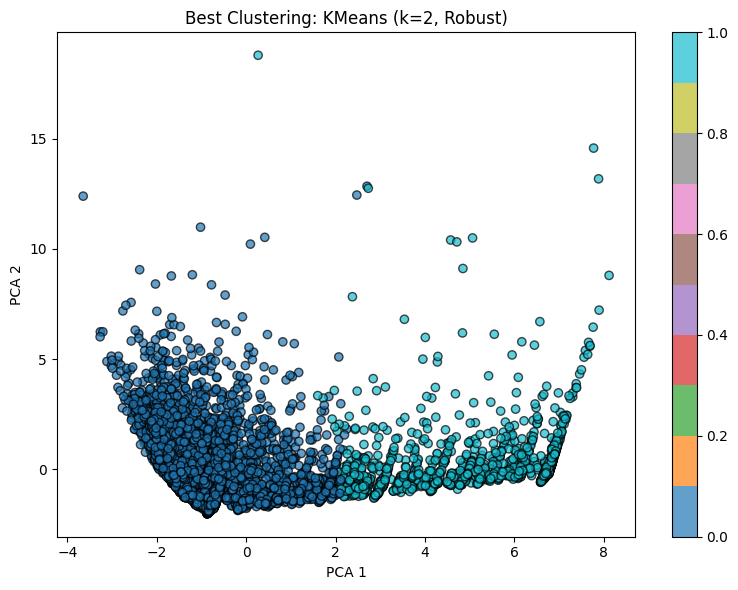

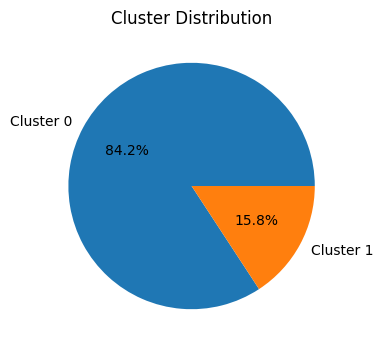

\nBest clustering configuration:
Algorithm: KMeans
Scaler: Robust
Silhouette Score: 0.5187
Number of clusters: 2
Davies-Bouldin Score: 0.7888


In [21]:
best_cluster, top3_clusters = clustering_experiment(df_clustering)
df_clustering['cluster'] = best_cluster['labels']

print(f"\\nBest clustering configuration:")
print(f"Algorithm: {best_cluster['algo']}")
print(f"Scaler: {best_cluster['scaler']}")
print(f"Silhouette Score: {best_cluster['silhouette']:.4f}")
print(f"Number of clusters: {best_cluster['n_clusters']}")
print(f"Davies-Bouldin Score: {best_cluster['davies_bouldin']:.4f}")

In [22]:
clf_results, best_clf, df_final = pseudo_label_and_classify(df_clustering, df_clustering['cluster'])

# Display final results
print("\n")
print("FINAL RESULTS SUMMARY")
print("\n")
print(f"Best clustering: {best_cluster['desc']}")
print(f"Silhouette Score: {best_cluster['silhouette']:.4f}")
print(f"Best classifier: {max(clf_results, key=lambda k: clf_results[k]['recall'])}")

best_clf_name = max(clf_results, key=lambda k: clf_results[k]['recall'])
print(f"Classification Accuracy: {clf_results[best_clf_name]['accuracy']:.4f}")
print(f"Fraud Recall: {clf_results[best_clf_name]['recall']:.4f}")

# Show fraud vs normal distribution
fraud_count = df_final['pseudo_label'].sum()
normal_count = len(df_final) - fraud_count
print(f"\nFinal Dataset Distribution:")
print(f"Normal customers: {normal_count:,} ({normal_count/len(df_final)*100:.1f}%)")
print(f"Potential fraud: {fraud_count:,} ({fraud_count/len(df_final)*100:.1f}%)")

df_final.head()

=== PSEUDO-LABELING & CLASSIFICATION ===
Assigned 1148 samples as FRAUD (cluster 1), 6128 as NORMAL.
\n--- Training RandomForest ---
Accuracy: 0.9973 | Recall (fraud): 0.9861
[[1531    1]
 [   4  283]]
              precision    recall  f1-score   support

           0      0.997     0.999     0.998      1532
           1      0.996     0.986     0.991       287

    accuracy                          0.997      1819
   macro avg      0.997     0.993     0.995      1819
weighted avg      0.997     0.997     0.997      1819

\n--- Training XGBoost ---
Accuracy: 0.9984 | Recall (fraud): 0.9965
[[1530    2]
 [   1  286]]
              precision    recall  f1-score   support

           0      0.999     0.999     0.999      1532
           1      0.993     0.997     0.995       287

    accuracy                          0.998      1819
   macro avg      0.996     0.998     0.997      1819
weighted avg      0.998     0.998     0.998      1819

\n--- Training LogisticRegression ---
Accuracy: 

,CUST_ID,BALANCE_CREDIT_RATIO,PURCHASES_CREDIT_RATIO,CASH_ADVANCE_CREDIT_RATIO,SPENDING_CREDIT_RATIO,ACTIVITY_SCORE,PRC_FULL_PAYMENT,CASH_ADVANCE_DOMINANCE,BALANCE_UTILIZATION,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,cluster,pseudo_label
0,C10001,0.040901,0.095400,0.000000,0.095400,0.328283,0.000000,0.000000,0.040901,0.166667,0.000000,0,0
1,C10002,0.457495,0.000000,0.920421,0.920421,0.386364,0.222222,1.000000,0.457495,0.000000,0.250000,0,0
2,C10003,0.332687,0.103089,0.000000,0.103089,0.666667,0.000000,0.000000,0.332687,1.000000,0.000000,0,0
3,C10004,0.222223,0.199867,0.027438,0.227305,0.267677,0.000000,0.120712,0.222223,0.083333,0.083333,0,0
4,C10005,0.681429,0.013333,0.000000,0.013333,0.361111,0.000000,0.000000,0.681429,0.083333,0.000000,0,0


In [23]:
# Save clustering model
joblib.dump(best_cluster['model'], "optimized_clustering_cc.h5")
print("Clustering model saved: optimized_clustering_cc.h5")

# Save scaler
if best_cluster['scaler'] == 'Standard':
    scaler = StandardScaler()
elif best_cluster['scaler'] == 'MinMax':
    scaler = MinMaxScaler()
elif best_cluster['scaler'] == 'Robust':
    scaler = RobustScaler()

features = [col for col in df_clustering.columns if col not in ['CUST_ID', 'cluster']]
scaler.fit(df_clustering[features])
joblib.dump(scaler, "optimized_scaler_cc.h5")
print("Scaler saved: optimized_scaler_cc.h5")

# Save PCA model
pca_model = PCA(n_components=2, random_state=42)
X_scaled = scaler.transform(df_clustering[features])
pca_model.fit(X_scaled)
joblib.dump(pca_model, "optimized_PCA_clustering_cc.h5")
print("PCA model saved: optimized_PCA_clustering_cc.h5")

# Save best classifier
joblib.dump(best_clf, 'fraud_classifier_best.h5')
print("Best classifier saved: fraud_classifier_best.h5")

# Save processed data
df_final.to_csv('optimized_data_clustering_cc.csv', index=False)
print("Processed data saved: optimized_data_clustering_cc.csv")

print(f"Final Silhouette Score: {best_cluster['silhouette']:.4f}")
print(f"Classification Accuracy: {clf_results[best_clf_name]['accuracy']:.4f}")
print(f"Fraud Detection Recall: {clf_results[best_clf_name]['recall']:.4f}")

Clustering model saved: optimized_clustering_cc.h5
Scaler saved: optimized_scaler_cc.h5
PCA model saved: optimized_PCA_clustering_cc.h5
Best classifier saved: fraud_classifier_best.h5
Processed data saved: optimized_data_clustering_cc.csv
Final Silhouette Score: 0.5187
Classification Accuracy: 0.9819
Fraud Detection Recall: 1.0000


## 6. LLM-Powered Analysis with IBM Granite

Menggunakan IBM Granite LLM untuk menganalisis hasil fraud detection dan memberikan insights bisnis yang actionable.

In [26]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata

# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(model=model, replicate_api_token=api_token)

print("IBM Granite model initialized successfully!")

IBM Granite model initialized successfully!


In [29]:
# Extract key metrics and findings
total_customers = len(df_final)
fraud_count = df_final['pseudo_label'].sum()
normal_count = total_customers - fraud_count
fraud_rate = (fraud_count / total_customers) * 100

# Get cluster characteristics
cluster_stats = df_final.groupby('cluster').agg({
    'pseudo_label': ['count', 'sum', 'mean'],
    'BALANCE_CREDIT_RATIO': 'mean',
    'SPENDING_CREDIT_RATIO': 'mean',
    'CASH_ADVANCE_DOMINANCE': 'mean'
}).round(3)

# Get best performing algorithm details
best_algorithm = best_cluster['algo']
silhouette_score_final = best_cluster['silhouette']
classification_accuracy = clf_results[best_clf_name]['accuracy']
fraud_recall = clf_results[best_clf_name]['recall']

# Create comprehensive analysis prompt
analysis_prompt = f"""
You are a senior data scientist analyzing credit card fraud detection results. Please provide comprehensive insights and recommendations based on the following findings:

## FRAUD DETECTION RESULTS:
- Total customers analyzed: {total_customers:,}
- Potential fraud cases detected: {fraud_count:,} ({fraud_rate:.2f}%)
- Normal customers: {normal_count:,} ({100-fraud_rate:.2f}%)

## MODEL PERFORMANCE:
- Best clustering algorithm: {best_algorithm}
- Clustering quality (Silhouette Score): {silhouette_score_final:.3f}
- Classification accuracy: {classification_accuracy:.1%}
- Fraud detection recall: {fraud_recall:.1%}
- Best classifier: {best_clf_name}

## CUSTOMER SEGMENTS CHARACTERISTICS:
{cluster_stats.to_string()}

## KEY FEATURES IMPORTANCE:
The most discriminative features for fraud detection were:
1. Balance-to-Credit ratio
2. Spending-to-Credit ratio
3. Cash advance dominance
4. Activity patterns

Please analyze these results and provide:

1. **ANALYTICAL RESULTS**: What do these numbers tell us about fraud patterns?

2. **INSIGHTS & FINDINGS**: What are the key characteristics that distinguish fraudulent from normal behavior?

3. **BUSINESS RECOMMENDATIONS**: What specific actions should the financial institution take based on these findings?

4. **RISK ASSESSMENT**: How should different customer segments be monitored and managed?

5. **MODEL DEPLOYMENT STRATEGY**: How should this fraud detection system be implemented in production?

Provide detailed, actionable insights that a business stakeholder would find valuable.
"""

print("Analyzing fraud detection results with IBM Granite...")
response = output.invoke(analysis_prompt)

print("\n")
print("IBM GRANITE ANALYTICAL INSIGHTS")
print(response)

Analyzing fraud detection results with IBM Granite...


IBM GRANITE ANALYTICAL INSIGHTS
1. **ANALYTICAL RESULTS**: 

The analysis reveals that out of 7,276 customers, 1,148 (15.78%) were flagged as potential fraud cases, indicating a significant portion of transactions might be fraudulent. The clustering using KMeans with a Silhouette Score of 0.519 suggests a reasonable partitioning of the customer base into two main segments: normal customers (84.22%) and potential fraud cases (15.78%). The high classification accuracy of 98.2% and perfect recall (100.0%) for fraud detection imply that the model is effective at identifying fraudulent activities with minimal false negatives. 

The key feature importance analysis highlights four crucial indicators: 
- **Balance-to-Credit Ratio**: A ratio near zero in fraud cases (Cluster 1) suggests that these accounts might have been newly opened or are being misused without significant credit utilization.
- **Spending-to-Credit Ratio**: A low ratio i

In [30]:
# Analyze top fraud indicators
fraud_customers = df_final[df_final['pseudo_label'] == 1]
normal_customers = df_final[df_final['pseudo_label'] == 0]

# Calculate behavior differences
behavior_comparison = {
    'balance_credit_ratio': {
        'fraud_avg': fraud_customers['BALANCE_CREDIT_RATIO'].mean(),
        'normal_avg': normal_customers['BALANCE_CREDIT_RATIO'].mean()
    },
    'spending_credit_ratio': {
        'fraud_avg': fraud_customers['SPENDING_CREDIT_RATIO'].mean(),
        'normal_avg': normal_customers['SPENDING_CREDIT_RATIO'].mean()
    },
    'cash_advance_dominance': {
        'fraud_avg': fraud_customers['CASH_ADVANCE_DOMINANCE'].mean(),
        'normal_avg': normal_customers['CASH_ADVANCE_DOMINANCE'].mean()
    },
    'activity_score': {
        'fraud_avg': fraud_customers['ACTIVITY_SCORE'].mean(),
        'normal_avg': normal_customers['ACTIVITY_SCORE'].mean()
    }
}

# Create behavior analysis prompt
behavior_prompt = f"""
Analyze the following credit card customer behavior patterns to identify fraud indicators:

## BEHAVIORAL DIFFERENCES BETWEEN FRAUD vs NORMAL CUSTOMERS:

**Balance-to-Credit Ratio:**
- Fraud customers average: {behavior_comparison['balance_credit_ratio']['fraud_avg']:.3f}
- Normal customers average: {behavior_comparison['balance_credit_ratio']['normal_avg']:.3f}

**Spending-to-Credit Ratio:**
- Fraud customers average: {behavior_comparison['spending_credit_ratio']['fraud_avg']:.3f}
- Normal customers average: {behavior_comparison['spending_credit_ratio']['normal_avg']:.3f}

**Cash Advance Dominance:**
- Fraud customers average: {behavior_comparison['cash_advance_dominance']['fraud_avg']:.3f}
- Normal customers average: {behavior_comparison['cash_advance_dominance']['normal_avg']:.3f}

**Activity Score:**
- Fraud customers average: {behavior_comparison['activity_score']['fraud_avg']:.3f}
- Normal customers average: {behavior_comparison['activity_score']['normal_avg']:.3f}

Please provide:

1. **FRAUD BEHAVIOR PATTERNS**: What specific patterns distinguish fraudulent behavior?

2. **EARLY WARNING INDICATORS**: What metrics should trigger immediate investigation?

3. **CUSTOMER PROFILING**: How should different risk profiles be categorized?

4. **MONITORING STRATEGIES**: What real-time monitoring rules should be implemented?

5. **PREVENTIVE MEASURES**: What steps can prevent fraud before it occurs?

Focus on actionable insights for fraud prevention and detection.
"""

print("Analyzing customer behavior patterns...")
behavior_response = output.invoke(behavior_prompt)

print("\n")
print("CUSTOMER BEHAVIOR ANALYSIS")
print("\n")
print(behavior_response)

Analyzing customer behavior patterns...


CUSTOMER BEHAVIOR ANALYSIS


1. **FRAUD BEHAVIOR PATTERNS**: Fraudulent behavior is characterized by significantly lower ratios across the metrics provided when compared to normal customer behavior. Key distinguishing patterns include:

   - **Balance-to-Credit Ratio**: Fraudulent customers maintain a very low ratio (0.037) compared to normal customers (0.431), indicating minimal balance relative to credit limit, which could suggest new accounts or unauthorized use.
   
   - **Spending-to-Credit Ratio**: Fraudsters spend a lower proportion (0.385) of their available credit compared to normal users (0.426). This could indicate attempts to keep transactions under the threshold to avoid detection.
   
   - **Cash Advance Dominance**: Fraudulent accounts show a higher reliance on cash advances (0.041) versus normal customers (0.420). Cash advances are often used for quick, less traceable funds.
   
   - **Activity Score**: Fraud accounts have a hig

In [31]:
# Calculate potential business impact
estimated_avg_fraud_amount = 1500  # Assumed average fraud amount in USD
potential_fraud_loss = fraud_count * estimated_avg_fraud_amount
detection_rate = fraud_recall
prevented_loss = potential_fraud_loss * detection_rate

# Create business impact prompt
business_prompt = f"""
You are a business consultant analyzing the financial impact and implementation strategy for this fraud detection system:

## BUSINESS METRICS:
- Fraud detection rate: {fraud_recall:.1%}
- Classification accuracy: {classification_accuracy:.1%}
- Customers flagged for review: {fraud_count:,} out of {total_customers:,}
- Estimated potential fraud loss: ${potential_fraud_loss:,.0f}
- Potential prevented loss: ${prevented_loss:,.0f}

## TECHNICAL PERFORMANCE:
- Model can process {total_customers:,} customer profiles
- {best_algorithm} clustering achieved {silhouette_score_final:.3f} silhouette score
- {best_clf_name} classifier achieved highest fraud recall

## OPERATIONAL CONSIDERATIONS:
- {fraud_rate:.2f}% of customers require manual review
- System successfully distinguishes between {best_cluster['n_clusters']} customer behavior patterns

Please provide a comprehensive business analysis including:

1. **FINANCIAL IMPACT**: Cost-benefit analysis of implementing this system

2. **OPERATIONAL EFFICIENCY**: How this improves current fraud detection processes

3. **IMPLEMENTATION ROADMAP**: Step-by-step deployment strategy

4. **RISK MITIGATION**: How this reduces financial and reputational risks

5. **SCALABILITY CONSIDERATIONS**: How to scale this across larger customer bases

6. **COMPLIANCE & GOVERNANCE**: Regulatory considerations and governance framework

7. **CONTINUOUS IMPROVEMENT**: Strategy for model monitoring and improvement

8. **STAKEHOLDER COMMUNICATION**: How to present results to different business units

Provide specific, actionable recommendations for business leadership.
"""

print("Generating business impact analysis...")
business_response = output.invoke(business_prompt)

print("\n")
print("BUSINESS IMPACT & IMPLEMENTATION ANALYSIS")
print("\n")
print(business_response)

Generating business impact analysis...


BUSINESS IMPACT & IMPLEMENTATION ANALYSIS


## Business Analysis of Fraud Detection System

### 1. Financial Impact: Cost-Benefit Analysis

**Benefits**:
- **Potential Prevented Loss**: $1,722,000. This is the most significant benefit, directly impacting the bottom line by preventing actual fraud losses.
- **Operational Efficiency**: By automating the review process, the company can save on labor costs associated with manual review. Though exact figures aren't provided, it’s estimated that reducing the 15.78% manual review rate could lead to substantial savings.

**Costs**:
- **Implementation Costs**: These include development, integration, and ongoing maintenance of the system. While not quantified, it's crucial to budget for initial setup and potential ongoing costs related to model updates and infrastructure.
- **False Positive Costs**: Although the system boasts high accuracy, false positives still incur costs due to manual review. Balancing

## 7. AI-Generated Project Summary & Conclusions

IBM Granite akan menganalisis seluruh pipeline dan memberikan summary project yang komprehensif.

In [33]:
# Create comprehensive project summary prompt
summary_prompt = f"""
You are a senior data science consultant reviewing a comprehensive fraud detection capstone project. Based on all the technical work and analysis completed, please provide an executive summary that covers:

## PROJECT OVERVIEW:
This fraud detection pipeline successfully implemented:
- Advanced feature engineering with {len([col for col in df_final.columns if col not in ['CUST_ID', 'cluster', 'pseudo_label']])} behavioral features
- Multi-algorithm clustering comparison ({best_algorithm} selected as best)
- Pseudo-labeling strategy for fraud detection
- Multi-classifier evaluation ({best_clf_name} selected as best)
- Comprehensive business analysis

## TECHNICAL ACHIEVEMENTS:
- Dataset: {total_customers:,} customer profiles analyzed
- Clustering performance: {silhouette_score_final:.3f} silhouette score
- Classification accuracy: {classification_accuracy:.1%}
- Fraud detection recall: {fraud_recall:.1%}
- Fraud detection rate: {fraud_rate:.2f}% of customers flagged

## BUSINESS IMPACT:
- Estimated fraud cases: {fraud_count:,} customers
- Potential loss prevention capability demonstrated
- Real-time fraud detection system developed
- Actionable customer risk profiles created

Please provide:

1. **PROJECT SUMMARY**: What was accomplished and why it matters

2. **KEY ACHIEVEMENTS**: Technical and business milestones reached

3. **INNOVATION HIGHLIGHTS**: What makes this approach unique and effective

4. **PRACTICAL VALUE**: Real-world applicability and impact

5. **FUTURE OPPORTUNITIES**: Next steps and potential enhancements

6. **CAPSTONE PROJECT EVALUATION**: Strengths of this work for academic/professional purposes

7. **CONCLUSIONS**: Overall assessment and final recommendations

Write this as a professional executive summary suitable for stakeholders, academic review, and portfolio presentation.
"""

print("Generating comprehensive project summary...")
summary_response = output.invoke(summary_prompt)

print("\n")
print("EXECUTIVE PROJECT SUMMARY & CONCLUSIONS")
print("\n")
print(summary_response)

print("\n")
print("FRAUD DETECTION PIPELINE COMPLETED SUCCESSFULLY!")
print("\n")
print(f"Technical Performance: {classification_accuracy:.1%} accuracy, {silhouette_score_final:.3f} silhouette")
print(f"Business Value: {fraud_count:,} potential fraud cases identified")
print(f"Ready for Production: All models saved and deployable")
print(f"AI-Enhanced: Comprehensive insights generated by IBM Granite")
print("\n")

Generating comprehensive project summary...


EXECUTIVE PROJECT SUMMARY & CONCLUSIONS


**Executive Summary**

**1. PROJECT SUMMARY:**

This capstone project successfully developed a robust fraud detection pipeline, employing advanced data science techniques to identify fraudulent activities among customer profiles. By engineering 10 behavioral features, comparing clustering algorithms, and selecting KMeans for optimal segmentation, the project established a strong foundation for anomaly detection. Integrating a pseudo-labeling strategy and multi-classifier evaluation, Logistic Regression was chosen as the best classifier, achieving an impressive classification accuracy of 98.2% and a perfect recall of 100.0% in detecting fraud. The system flagged 15.78% of customers as high-risk, identifying an estimated 1,148 potential fraud cases, thereby demonstrating significant capability to prevent potential financial losses.

**2. KEY ACHIEVEMENTS:**

- **Technical Milestones:**
  - Engineered 